In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
from IPython.display import display

demand_data = """
chip, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
logic, 88, 125, 260, 217, 238, 286, 248, 238, 265, 293, 259, 244
memory, 47, 62, 81, 65, 95, 118, 86, 89, 82, 82, 84, 66
"""

price_data = """
product, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
copper, 1, 1, 1, 2, 2, 3, 3, 2, 2, 1, 1, 2
silicon, 4, 3, 3, 3, 5, 5, 6, 5, 4, 3, 3, 5
germanium, 5, 5, 5, 3, 3, 3, 3, 2, 3, 4, 5, 6
plastic, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
"""

demand_chips = pd.read_csv(StringIO(demand_data), index_col="chip")
display(demand_chips)

price = pd.read_csv(StringIO(price_data), index_col="product")
display(price)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
logic,88,125,260,217,238,286,248,238,265,293,259,244
memory,47,62,81,65,95,118,86,89,82,82,84,66


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product,,,,,,,,,,,,
copper,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0
silicon,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,4.0,3.0,3.0,5.0
germanium,5.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,6.0
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [3]:
use = dict()
use["logic"] = {"silicon": 1, "plastic": 1, "copper": 4}
use["memory"] = {"germanium": 1, "plastic": 1, "copper": 2}
use = pd.DataFrame.from_dict(use).fillna(0).astype(int)
display(use)

demand = use.dot(demand_chips)
display(demand)

,logic,memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


Index([' Jan', ' Feb', ' Mar', ' Apr', ' May', ' Jun', ' Jul', ' Aug', ' Sep',
       ' Oct', ' Nov', ' Dec'],
      dtype='object')

In [108]:
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [114]:
def BIMProductAcquisitionAndInventory(
    demand, acquisition_price, existing, desired, stock_limit, month_budget
):
    m = pyo.ConcreteModel("BIM product acquisition and inventory")

    periods = demand.columns
    products = demand.index
    first = periods[0]
    prev = {j: i for i, j in zip(periods, periods[1:])}
    last = periods[-1]

    m.T = pyo.Set(initialize=periods)
    m.P = pyo.Set(initialize=products)
    m.PT = m.P * m.T  # to avoid internal set bloat

    m.x = pyo.Var(m.PT, domain=pyo.NonNegativeReals)
    m.s = pyo.Var(m.PT, domain=pyo.NonNegativeReals)

    @m.Param(m.PT)
    def pi(m, p, t):
        return acquisition_price.loc[p][t]

    @m.Param(m.PT)
    def h(m, p, t):
        return 0.05  # the holding cost

    @m.Param(m.PT)
    def delta(m, p, t):
        return demand.loc[p, t]

    @m.Expression()
    def acquisition_cost(m):
        return pyo.quicksum(m.pi[p, t] * m.x[p, t] for p in m.P for t in m.T)

    @m.Expression()
    def inventory_cost(m):
        return pyo.quicksum(m.h[p, t] * m.s[p, t] for p in m.P for t in m.T)

    @m.Objective(sense=pyo.minimize)
    def total_cost(m):
        return m.acquisition_cost + m.inventory_cost

    @m.Constraint(m.PT)
    def balance(m, p, t):
        if t == first:
            return existing[p] + m.x[p, t] == m.delta[p, t] + m.s[p, t]
        return m.x[p, t] + m.s[p, prev[t]] == m.delta[p, t] + m.s[p, t]

    @m.Constraint(m.P)
    def finish(m, p):
        return m.s[p, last] >= desired[p]

    @m.Constraint(m.T)
    def inventory(m, t):
        return pyo.quicksum(m.s[p, t] for p in m.P) <= stock_limit

    @m.Constraint(m.T)
    def budget(m, t):
        return pyo.quicksum(m.pi[p, t] * m.x[p, t] for p in m.P) <= month_budget

    return m


The optimal amounts of raw materials to acquire in each month are:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,0.0,0.0,0.0,965.0,0.0,0.0,0.0,0.0,0.0,1078.1,217.9,0.0
plastic,0.0,0.0,0.0,0.0,0.0,0.0,266.0,327.0,347.0,375.0,343.0,1310.0
copper,0.0,0.0,3548.0,0.0,0.0,0.0,0.0,0.0,962.0,1336.0,4312.0,0.0
germanium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



The corresponding optimal stock levels in each months are:


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912.0,787.0,527.0,1275.0,1037.0,751.0,503.0,265.0,0.0,785.1,744.0,500.0
plastic,1615.0,1428.0,1087.0,805.0,472.0,68.0,0.0,0.0,0.0,0.0,0.0,1000.0
copper,4354.0,3730.0,6076.0,5078.0,3936.0,2556.0,1392.0,262.0,0.0,0.0,3108.0,2000.0
germanium,1453.0,1391.0,1310.0,1245.0,1150.0,1032.0,946.0,857.0,775.0,693.0,609.0,543.0



The stock levels can be visualized as follows


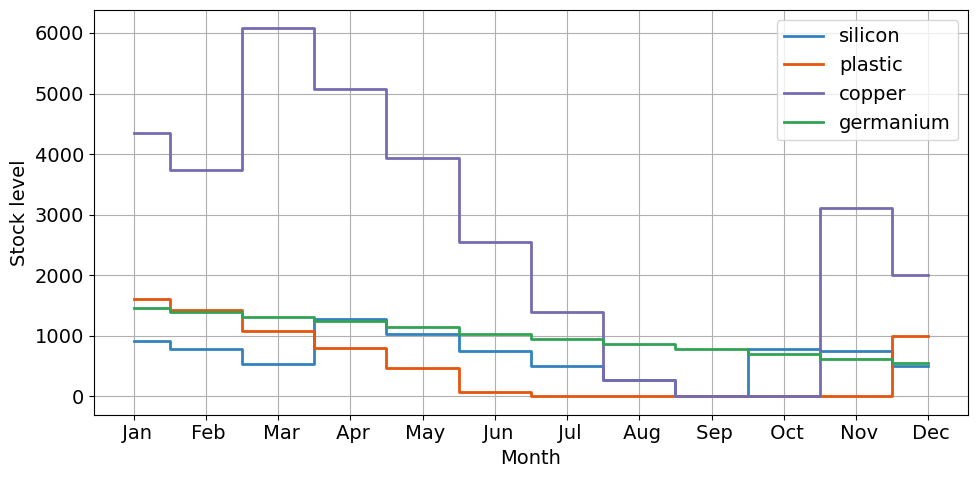

In [116]:
budget = 5000
m = BIMProductAcquisitionAndInventory(
    demand,
    price,
    {"silicon": 1000, "germanium": 1500, "plastic": 1750, "copper": 4800},
    {"silicon": 500, "germanium": 500, "plastic": 1000, "copper": 2000},
    9000,
    budget,
)
SOLVER.solve(m)


def show_table_of_pyomo_variables(X, I, J):
    return pd.DataFrame.from_records(
        [[pyo.value(X[i, j]) for j in J] for i in I], index=I, columns=J
    ).round(2)


def report_pyomo_solution(m):
    print("\nThe optimal amounts of raw materials to acquire in each month are:")
    display(show_table_of_pyomo_variables(m.x, m.P, m.T))

    print("\nThe corresponding optimal stock levels in each months are:")
    stock = show_table_of_pyomo_variables(m.s, m.P, m.T)
    display(stock)

    print("\nThe stock levels can be visualized as follows")
    plt.rcParams["font.size"] = 14
    colors = plt.get_cmap("tab20c")
    equidistant_colors = [colors(0.0), colors(0.2), colors(0.6), colors(0.4)]
    ax = stock.T.plot(
        drawstyle="steps-mid",
        lw=2,
        grid=True,
        figsize=(10, 5),
        color=equidistant_colors,
    )
    ax.legend(loc="upper right")
    ax.set_xticks(ticks=range(len(stock.columns)))
    ax.set_xticklabels(stock.columns)
    ax.set_xlabel("Month")
    ax.set_ylabel("Stock level")
    plt.tight_layout()
    plt.show()


report_pyomo_solution(m)